**Task 1:**

Read the code of the Ant Colony Optimization algorithm (ACO) to familiarize yourself with the methods and variables used. Complete the code by filling the methods marked with #TODO in classes *Problem* and *TSP*.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

**Pheromone update:**

$$\tau _{xy}\leftarrow (1-\rho )\tau _{xy}+\sum _{k}\Delta \tau _{xy}^{k}$$

$$\Delta \tau _{xy}^{k}={\begin{cases}q/L_{k}&{\mbox{if ant }}k{\mbox{ uses curve }}xy{\mbox{ in its tour}}\\0&{\mbox{otherwise}}\end{cases}}$$

In [34]:
class Problem:
    name_to_id = {} # translates the name of an element of a solution to its ID (to be used in arrays)
    parts_phero = []  # the amount of pheromones on an element of a solution
    parts_phero_delta = [] # the amount of pheromones added to the element by the ants in a given iteration
    
    min_prob = True # is this a minimization problem?
    
    alpha = 1 # importance of the pheromone level
    beta = 1 # importance of the heuristic knowledge
    ro = 0.5 # pheromone evaporation coefficient
    q = 10 # multiplier of the pheromone deposit

    
    ### these methods MUST be implemented in the INHERITING class ###
    
    # initialization of the problem: initializing name_to_id, parts_phero, 
    # parts_phero_delta and other arrays used by the problem
    def __init__(self):
        pass

    # returns a random starting point for a new solution
    def initial_solution(self):
        return []
    
    # returns a list of all the elements making up a given solution
    def solution_parts(self, solution):
        return []

    # returns a value of the goal function for a given solution to the problem
    def solution_quality(self, solution):
        return 0
    
    # returns lists of the elements that can be added to the solution, 
    # and the probabilities of them being added
    def possible_choices(self, part_solution):
        return [], []
    
    
    ### these methods CAN be implemented in the INHERITING class ###
    
    # shows the given solution
    def display_solution(self, solution):
        pass
    
    # shows the current distribution of the pheromones
    def display_pheromones(self):
        pass

    
    #### these methods MUST be implemented HERE ###
    def apply_pheromones(self, solution):
        # TODO add pheromones to parts_phero_delta
        # for all elements in the solution (self.solution_parts(solution))
        # remember to check min_prob!
        objective = self.solution_quality(solution)
        for part in self.solution_parts(solution):
            self.parts_phero_delta[part] += self.q / objective

    def update_pheromones(self):
        # TODO update the array of pheromone levels parts_phero based on 
        # the parts_phero_delta from this iteration of the algorithm
        for i, delta in enumerate(self.parts_phero_delta):
            self.parts_phero[i] += delta
            self.parts_phero[i] *= (1 - self.ro)
        self.parts_phero_delta = [0 for i in range(len(self.parts_phero))]

    def construction_step(self, part_solution):
        choices, probs = self.possible_choices(part_solution)
        roulette = random.random()
        cumulative = 0
        next_part = None
        for choice, prob in zip(choices, probs):
            cumulative += prob
            if roulette < cumulative:
                next_part = choice
                break
        return part_solution + [next_part]

    def walk(self):
        solution = self.initial_solution()
        while len(self.possible_choices(solution)[0]) > 0:
            solution = self.construction_step(solution)
        return solution
    
    def reset_pheromones(self):
        self.parts_phero = [1 for i in range(len(self.parts_phero))]
        self.parts_phero_delta = [0 for i in range(len(self.parts_phero))]
    
    def solve(self, iterations = 1000, ants = 100, alpha = 1, beta = 1, ro = 0.5, q = 100, display_period = 100):
        self.alpha = alpha
        self.beta = beta
        self.ro = ro
        self.q = q
        
        best_sol = None
        best_sol_q = (float('inf') if self.min_prob else float('-inf'))
        for j in range(iterations):
            for i in range(ants):
                sol = self.walk() # construct a single solution
                self.apply_pheromones(sol) # update parts_phero_delta for this solution
                sol_q = self.solution_quality(sol)
                if (self.min_prob and sol_q < best_sol_q) or (not self.min_prob and sol_q > best_sol_q):
                    best_sol = sol
                    best_sol_q = sol_q
            self.update_pheromones() # update parts_phero for this iteration
            
            if j%display_period == 0:
                self.display_pheromones()
                self.display_solution(best_sol)
                print(best_sol, best_sol_q)
                
        return best_sol, best_sol_q

**Edge selection:**

$$p_{xy}^{k}={\frac {(\tau _{xy}^{\alpha })(\eta _{xy}^{\beta })}{\sum _{z\in \mathrm {allowed} _{x}}(\tau _{xz}^{\alpha })(\eta _{xz}^{\beta })}}$$

Remember: the solution is an array of cities, but the pheromones are being put on the edges between cities

In [38]:
class TSP(Problem):
    cities = []
    distance = []
    coords = {}

    def dist(self, x1, y1, x2, y2):
        return ((x1-x2)**2+(y1-y2)**2)**(1/2)

    def __init__(self):
        super().__init__()
        self.cities.extend(["Poznan", "Wroclaw", "Krakow", "Warszawa", "Gdansk", "Katowice", "Lodz",
                       "Bialystok", "Rzeszow", "Szczecin", "Lublin", "Olsztyn", "Kielce", "Gdynia", "Bydgoszcz", "Zakopane"])
        self.coords = {
            "Poznan": (52.409538, 16.931992),
            "Wroclaw": (51.107883, 17.038538),
            "Krakow": (50.049683, 19.944544),
            "Warszawa": (52.237049, 21.017532),
            "Gdansk": (54.372158, 18.638306),
            "Katowice": (50.270908, 19.039993),
            "Lodz": (51.759445, 19.457216),
            "Bialystok": (53.13333, 23.16433),
            "Rzeszow": (50.041187, 21.999121),
            "Szczecin": (53.42894, 14.55302),
            "Lublin": (51.25, 22.56667),
            "Olsztyn": (53.77995, 20.49416),
            "Kielce": (50.87033, 20.62752),
            "Gdynia": (54.51889, 18.53188),
            "Bydgoszcz": (53.1235, 18.00762),
            "Zakopane": (49.29899, 19.94885)
        }

        id = 0
        for c1 in self.cities:
            for c2 in self.cities:
                self.name_to_id[c1+"-"+c2] = id
                self.parts_phero.append(1)
                self.parts_phero_delta.append(0)
                self.distance.append(self.dist(self.coords[c1][0], self.coords[c1][1],
                                               self.coords[c2][0], self.coords[c2][1]))
                id += 1

    def possible_choices(self, part_solution):
        choices = []
        probs = []
        
        choices = list(set(self.cities) - set(part_solution))
        assert(len(part_solution) > 0)
        edge_ids = [self.solution_parts([part_solution[-1], city])[0] for city in choices]
        probs = [
            self.parts_phero[edge_id]**self.alpha / self.distance[edge_id]**self.beta
            for edge_id in edge_ids
        ]
        total = sum(probs)
        probs = [prob / total for prob in probs]
        return choices, probs

    def solution_quality(self, solution):
        return sum(self.distance[edge_id] for edge_id in self.solution_parts(solution))
    
    def solution_parts(self, solution):
        return [
            self.name_to_id[f"{city1}-{city2}"]
            for city1, city2
            in zip(solution, solution[1:])
        ] + [self.name_to_id[f"{solution[-1]}-{solution[0]}"]]

    def initial_solution(self):
        return [random.choice(self.cities)]
    
    ### DISPLAY (you don't have to read it) ###

    def force_aspect(self, ax,aspect=1):
        im = ax.get_images()
        extent =  im[0].get_extent()
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

    def display_pheromones(self):
        self.display_pheromones_param(True, [11.328361, 27.045778], [49.0025, 54.835778])
        
    def display_pheromones_param(self, show_map, xlim, ylim):
        fig, ax = plt.subplots(figsize=(8, 8))

        if show_map:
            datafile = 'polska.png'
            img = mpimg.imread(datafile)
            plt.imshow(img, zorder=0, extent=[14.245, 24.129139, 49.0025, 54.835778])

        
        for c1 in self.cities:
            for c2 in self.cities:
                x = [self.coords[c1][1], self.coords[c2][1]]
                y = [self.coords[c1][0], self.coords[c2][0]]
                #print(x)
                line, = ax.plot(x, y, 'ro-', 
                                linewidth=3*self.parts_phero[self.name_to_id[c1+"-"+c2]]/max(self.parts_phero))

        if show_map:
            plt.xlabel('Długosc geograficzna')
            plt.ylabel('Szerokosc geograficzna')
            self.force_aspect(ax)
            
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.show()
        
        
    def display_solution(self, solution):
        self.display_solution_param(solution, True, [11.328361, 27.045778], [49.0025, 54.835778])
        
    def display_solution_param(self, solution, show_map, xlim, ylim):
        fig, ax = plt.subplots(figsize=(8, 8))
        
        if show_map:
            datafile = 'polska.png'
            img = mpimg.imread(datafile)
            plt.imshow(img, zorder=0, extent=[14.245, 24.129139, 49.0025, 54.835778])

        x = [i[1] for i in [self.coords[c] for c in solution]]
        y = [i[0] for i in [self.coords[c] for c in solution]]
        x.append(x[0])
        y.append(y[0])
        line, = ax.plot(x, y, 'go-',linewidth=2)

        if show_map:
            plt.xlabel('Długosc geograficzna')
            plt.ylabel('Szerokosc geograficzna')
            self.force_aspect(ax)
            
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.show()

**Task 2:**

- Test if your implementation works correctly
- Observe how the distribution of pheromones changes in time
- Is the optimal route clearly visible in the distribution of pheromones? If not - why?

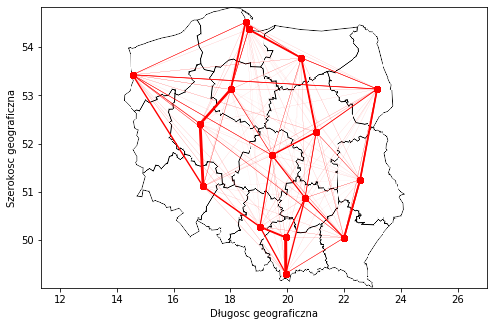

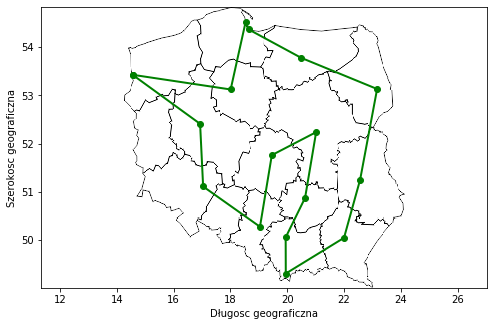

['Szczecin', 'Poznan', 'Wroclaw', 'Katowice', 'Lodz', 'Warszawa', 'Kielce', 'Krakow', 'Zakopane', 'Rzeszow', 'Lublin', 'Bialystok', 'Olsztyn', 'Gdansk', 'Gdynia', 'Bydgoszcz'] 27.808078968589495


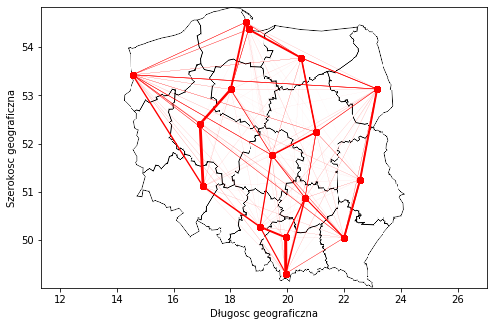

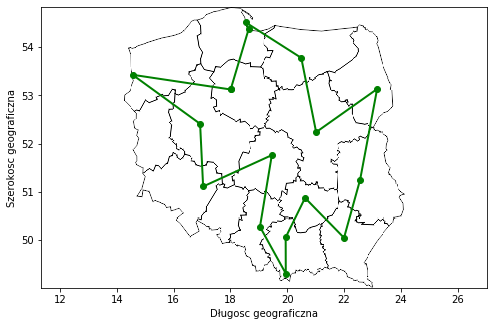

['Bydgoszcz', 'Gdansk', 'Gdynia', 'Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw', 'Poznan', 'Szczecin'] 27.10874392350699


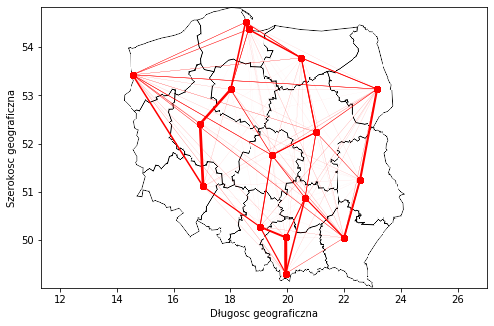

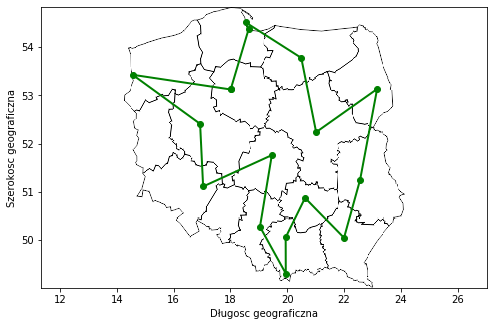

['Bydgoszcz', 'Gdansk', 'Gdynia', 'Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw', 'Poznan', 'Szczecin'] 27.10874392350699


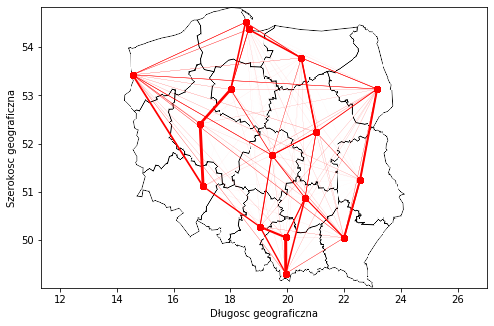

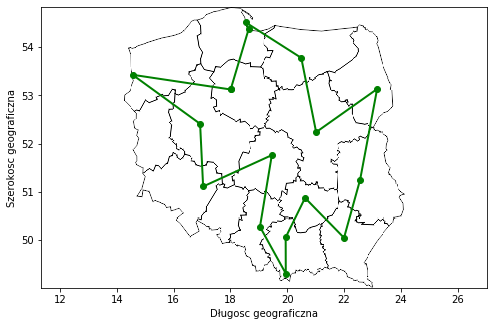

['Bydgoszcz', 'Gdansk', 'Gdynia', 'Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw', 'Poznan', 'Szczecin'] 27.10874392350699


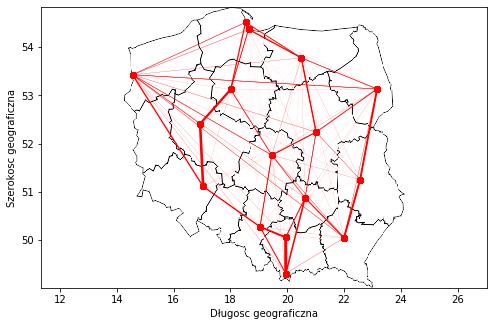

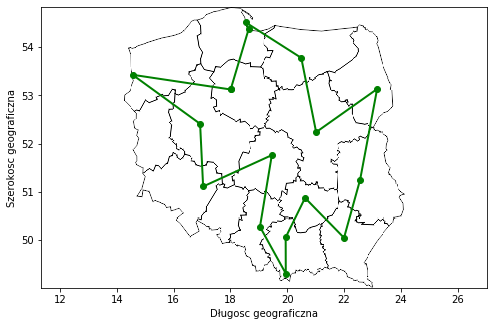

['Bydgoszcz', 'Gdansk', 'Gdynia', 'Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw', 'Poznan', 'Szczecin'] 27.10874392350699


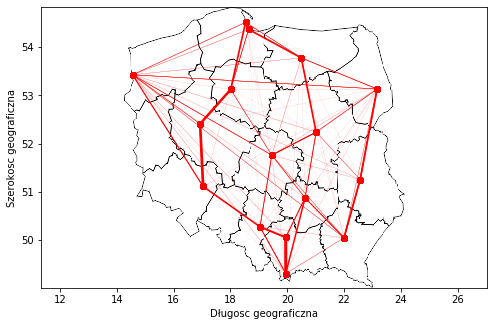

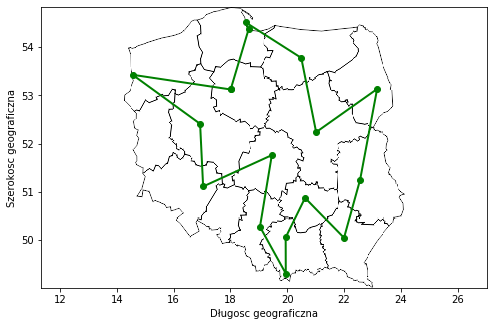

['Bydgoszcz', 'Gdansk', 'Gdynia', 'Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw', 'Poznan', 'Szczecin'] 27.10874392350699


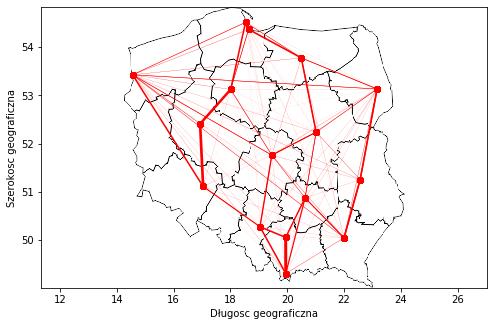

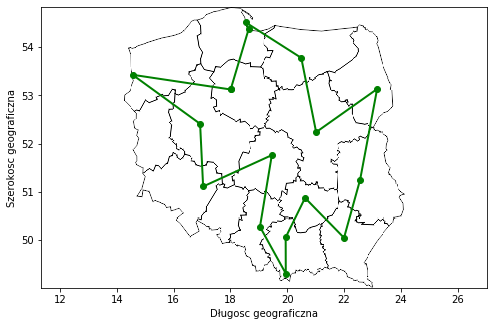

['Bydgoszcz', 'Gdansk', 'Gdynia', 'Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw', 'Poznan', 'Szczecin'] 27.10874392350699


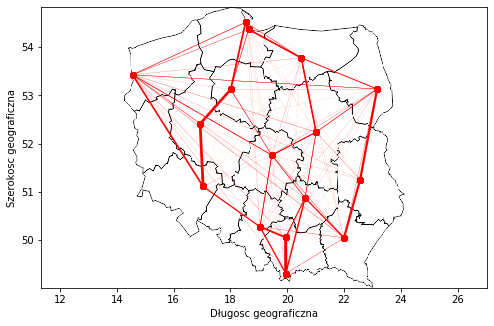

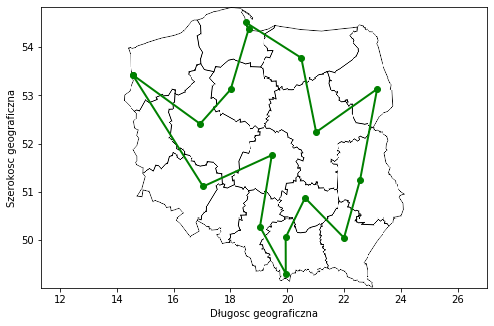

['Szczecin', 'Poznan', 'Bydgoszcz', 'Gdansk', 'Gdynia', 'Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw'] 27.026423832288263


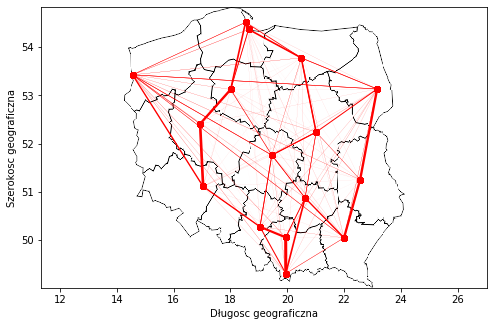

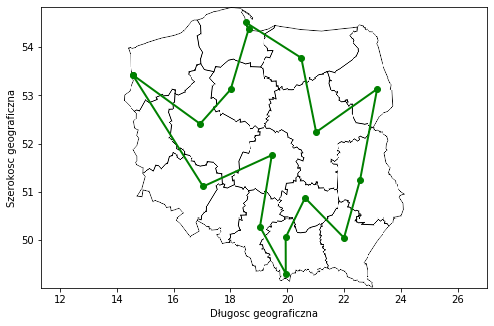

['Szczecin', 'Poznan', 'Bydgoszcz', 'Gdansk', 'Gdynia', 'Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw'] 27.026423832288263


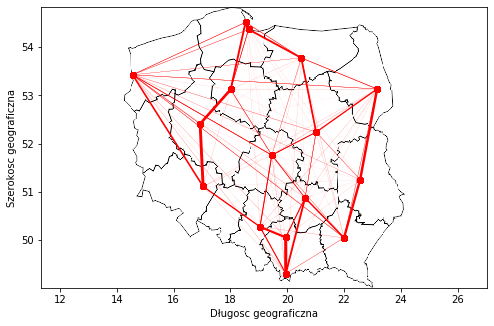

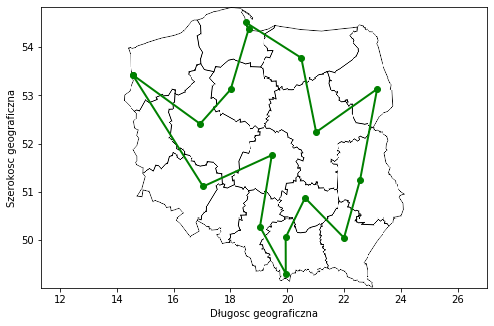

['Szczecin', 'Poznan', 'Bydgoszcz', 'Gdansk', 'Gdynia', 'Olsztyn', 'Warszawa', 'Bialystok', 'Lublin', 'Rzeszow', 'Kielce', 'Krakow', 'Zakopane', 'Katowice', 'Lodz', 'Wroclaw'] 27.026423832288263


(['Szczecin',
  'Poznan',
  'Bydgoszcz',
  'Gdansk',
  'Gdynia',
  'Olsztyn',
  'Warszawa',
  'Bialystok',
  'Lublin',
  'Rzeszow',
  'Kielce',
  'Krakow',
  'Zakopane',
  'Katowice',
  'Lodz',
  'Wroclaw'],
 27.026423832288263)

In [39]:
tsp = TSP()
tsp.solve(iterations = 100, ants = 100, alpha = 1, beta = 3, ro = 0.5, q = 10, display_period = 10)

In [40]:
class TSPrand(TSP):
    def __init__(self):
        self.cities.extend([str(i) for i in range(30)])
        for c in self.cities:
            self.coords[c] = (random.random()*100, random.random()*100)

        id = 0
        for c1 in self.cities:
            for c2 in self.cities:
                self.name_to_id[c1+"-"+c2] = id
                self.parts_phero.append(1)
                self.parts_phero_delta.append(0)
                self.distance.append(self.dist(self.coords[c1][0], self.coords[c1][1],
                                               self.coords[c2][0], self.coords[c2][1]))
                id += 1
                
    def display_pheromones(self):
        self.display_pheromones_param(False, [0, 100], [0, 100])
        
    def display_solution(self, solution):
        self.display_solution_param(solution, False, [0, 100], [0, 100])

**Task 3:**

- How do the parameters influence the behavior of the algorithm?
- How does the heuristic knowledge influence the behavior of the algorithm? Is it necessary?
- Which parameters influence the convergence speed in ACO?
- Which parts of the solution are the first to be determined by ACO?
- How would you describe the behavior of the algorithm? How does it construct new, better solutions?


- What are the strengths of ACO?
- What are its weaknesses?
- How would you modify the ACO algorithm?
- For solving which problems is ACO best suited?


In [ ]:
tsp = TSPrand()
tsp.solve(iterations = 1000, ants = 10, alpha = 1, beta = 1, ro = 0.5, q = 10, display_period = 10)

**Task 4:**


Implement the Knapsack problem. Use ACO to solve it.

In [ ]:
from collections import namedtuple

Item = namedtuple('Item', ['weight', 'price'])

class Knapsack(Problem):
    # initialization of the problem: initializing name_to_id, parts_phero, 
    # parts_phero_delta and other arrays used by the problem
    def __init__(self, num_items):
        self.num_items = [for _ in range()]

    # returns a random starting point for a new solution
    def initial_solution(self):
        return []
    
    # returns a list of all the elements making up a given solution
    def solution_parts(self, solution):
        return []

    # returns a value of the goal function for a given solution to the problem
    def solution_quality(self, solution):
        return 0
    
    # returns lists of the elements that can be added to the solution, 
    # and the probabilities of them being added
    def possible_choices(self, part_solution):
        return [], []
    
knap = Knapsack(size = 40)
knap.solve(iterations = 100, ants = 100, alpha = 1, beta = 1, ro = 0.5, q = 0.1, display_period = 10)
        